In [1]:
import numpy as np
from scipy.io.idl import readsav
import os
from sunpy.map import Map


import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib

import dem_rml

# Read temperature response matrix

In [2]:
data  = readsav(os.path.join('.','data','tr_matrix_data.sav'))
# AIA temperature response function
tresp = data['TR']
# array containing the value of the base 10 logarithm of the center of each temparture bin
logT  = data['logT']
# array containing the value of the width of the base 10 logarithm of the temperature bins
dlogT = data['dlogT']

# Read AIA data

In [7]:
# Read AIA maps in the following order 94, 131, 171, 193 and 211

sorted_wavs = [94, 131, 171, 193, 211] 
path_files  = os.path.join('..','aia_fits','aia.lev1_euv_12s.2010-11-03T121518Z')

aia_maps = []
exptime  = [] 
for i in range(5):
    
    this_aia_map = Map(path_files + '.' + str(sorted_wavs[i]) + '.image.fits')
    aia_maps.append(this_aia_map.data)
    exptime.append(this_aia_map.meta['exptime'])

aia_maps = np.array(aia_maps, dtype = np.dtype('f8'))
exptime  = np.array(exptime, dtype = np.dtype('f16'))

In [8]:
# Values <= 0 are set equal to 1e-3 to avoid numerical problems
idx = np.where(aia_maps <= 0)
if len(idx[0]) > 0:
    aia_maps[idx] = 1e-3

# Normalize AIA data by exposure time
for i in range(len(sorted_wavs)):
    aia_maps[i,:,:] = aia_maps[i,:,:] / exptime[i]

# Compute uncertainty in AIA data

In [9]:
this_aia_maps = np.zeros(aia_maps.shape)
for i in range(len(sorted_wavs)):
    this_aia_maps[i,:,:] = aia_maps[i,:,:] * exptime[i]

sigmadn = dem_rml.AIAEstimateError(this_aia_maps, sorted_wavs)
for i in range(len(sorted_wavs)):
    sigmadn[i,:,:] = sigmadn[i,:,:] / exptime[i]

# Reconstruct DEM profiles

In [10]:
rml_dem, rml_dem_error, lam_pixel = dem_rml.dem_rml(aia_maps, sigmadn, exptime, tresp, logT, dlogT)


Start

Current value of the regularizarion parameter: 1.000
Current value of the regularizarion parameter: 0.667
Current value of the regularizarion parameter: 0.444
Current value of the regularizarion parameter: 0.296
Current value of the regularizarion parameter: 0.198
Current value of the regularizarion parameter: 0.132
Current value of the regularizarion parameter: 0.088
Current value of the regularizarion parameter: 0.059
Current value of the regularizarion parameter: 0.039
Current value of the regularizarion parameter: 0.026
Current value of the regularizarion parameter: 0.017
Current value of the regularizarion parameter: 0.012
Current value of the regularizarion parameter: 0.008
Current value of the regularizarion parameter: 0.005
Current value of the regularizarion parameter: 0.003
Current value of the regularizarion parameter: 0.002
Current value of the regularizarion parameter: 0.002
Current value of the regularizarion parameter: 0.001
Current value of the regularizarion pa

# Plot reconstructions

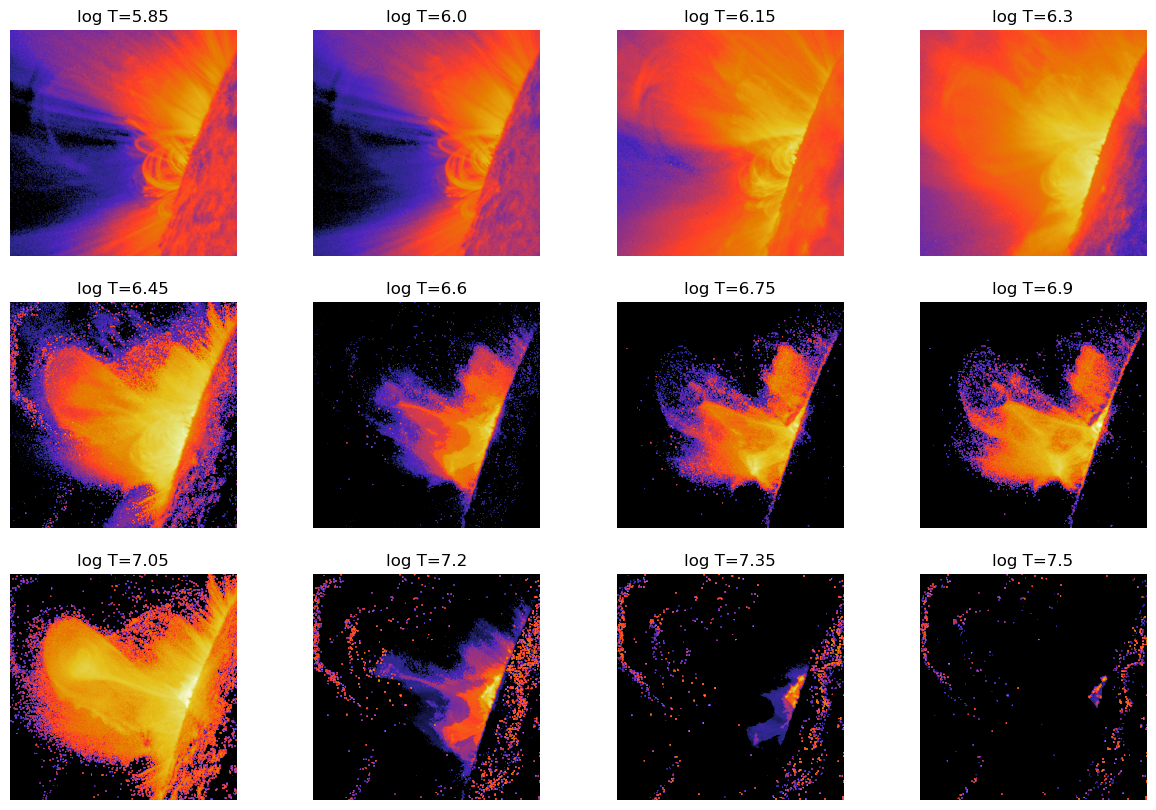

In [10]:
dmin = [1e19,1e19,1e19,1e19,1e17,1e17,1e17,1e17,1e15,1e15,1e15,1e15]
dmax = 3e22

nrows=3
ncols=4

plt.figure(figsize=(15,10))

for i in range(12):
    
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(rml_dem[i, :,:],norm=LogNorm(vmin=dmin[i], vmax=dmax, clip=True), cmap=matplotlib.colormaps['CMRmap'])
    plt.axis('off')
    plt.title("log T="+f"{logT[i]:.3}")

plt.show()